In [1]:
import sys
# sys.path.insert(0, '../../Utilities/')
from mpl_toolkits import mplot3d
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\COMPOSITE NEW_.csv")

In [4]:
q_z= df.loc[:,["Directional Heat Flux (Z)" ]] 

In [5]:
q_z.shape

(38445, 1)

In [6]:
q_z_new=np.array(q_z)

In [7]:
q_z_new_sq=np.square(q_z_new)

In [8]:
q_x= df.loc[:,["Directional Heat Flux (X)" ]] 

In [9]:
q_x_new=np.array(q_x)

In [10]:
q_x_new_sq=np.square(q_x_new)

In [11]:
q_final = np.sqrt((q_x_new_sq+q_z_new_sq))

In [12]:
x_y=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [13]:
x_y=np.array(x_y)

In [14]:
u=df.loc[:,"Temperature (K)"]

In [15]:
u=np.array(u)

In [16]:
u=u.reshape(38445,1)

In [17]:
N_u_1=3000
layers1 = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [18]:
lb1 = x_y.min(0)
ub1 = x_y.max(0)

In [19]:
idx = np.random.choice(x_y.shape[0], N_u_1, replace=False)
X_u_train = x_y[idx,:]
u_train = u[idx,:]
# q = scaled_q[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)
# q_= tf.convert_to_tensor(q,dtype=tf.float32)

In [20]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(20000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 3.564e+00, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.59
It: 10, Loss: 2.878e+00, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.11
It: 20, Loss: 2.375e+00, Lambda_1: 0.020, Lambda_2: 1.000000, Time: 0.10
It: 30, Loss: 2.043e+00, Lambda_1: 0.031, Lambda_2: 1.000000, Time: 0.09
It: 40, Loss: 1.855e+00, Lambda_1: 0.042, Lambda_2: 1.000000, Time: 0.17
It: 50, Loss: 1.767e+00, Lambda_1: 0.054, Lambda_2: 1.000000, Time: 0.24
It: 60, Loss: 1.737e+00, Lambda_1: 0.065, Lambda_2: 1.000000, Time: 0.16
It: 70, Loss: 1.731e+00, Lambda_1: 0.076, Lambda_2: 1.000000, Time: 0.15
It: 80, Loss: 1.731e+00, Lambda_1: 0

It: 1070, Loss: 7.284e-01, Lambda_1: 2.135, Lambda_2: 1.000000, Time: 0.14
It: 1080, Loss: 7.239e-01, Lambda_1: 2.142, Lambda_2: 1.000000, Time: 0.14
It: 1090, Loss: 7.194e-01, Lambda_1: 2.149, Lambda_2: 1.000000, Time: 0.14
It: 1100, Loss: 7.147e-01, Lambda_1: 2.156, Lambda_2: 1.000000, Time: 0.14
It: 1110, Loss: 7.098e-01, Lambda_1: 2.163, Lambda_2: 1.000000, Time: 0.14
It: 1120, Loss: 7.048e-01, Lambda_1: 2.170, Lambda_2: 1.000000, Time: 0.14
It: 1130, Loss: 6.995e-01, Lambda_1: 2.177, Lambda_2: 1.000000, Time: 0.18
It: 1140, Loss: 6.941e-01, Lambda_1: 2.184, Lambda_2: 1.000000, Time: 0.21
It: 1150, Loss: 6.883e-01, Lambda_1: 2.190, Lambda_2: 1.000000, Time: 0.21
It: 1160, Loss: 6.822e-01, Lambda_1: 2.196, Lambda_2: 1.000000, Time: 0.21
It: 1170, Loss: 6.755e-01, Lambda_1: 2.202, Lambda_2: 1.000000, Time: 0.21
It: 1180, Loss: 6.679e-01, Lambda_1: 2.208, Lambda_2: 1.000000, Time: 0.21
It: 1190, Loss: 6.591e-01, Lambda_1: 2.214, Lambda_2: 1.000000, Time: 0.21
It: 1200, Loss: 6.492e-01

It: 2170, Loss: 1.624e-01, Lambda_1: 2.099, Lambda_2: 1.000000, Time: 0.14
It: 2180, Loss: 1.620e-01, Lambda_1: 2.094, Lambda_2: 1.000000, Time: 0.14
It: 2190, Loss: 1.616e-01, Lambda_1: 2.090, Lambda_2: 1.000000, Time: 0.14
It: 2200, Loss: 1.612e-01, Lambda_1: 2.086, Lambda_2: 1.000000, Time: 0.14
It: 2210, Loss: 1.609e-01, Lambda_1: 2.082, Lambda_2: 1.000000, Time: 0.14
It: 2220, Loss: 1.606e-01, Lambda_1: 2.078, Lambda_2: 1.000000, Time: 0.14
It: 2230, Loss: 1.604e-01, Lambda_1: 2.073, Lambda_2: 1.000000, Time: 0.14
It: 2240, Loss: 1.607e-01, Lambda_1: 2.069, Lambda_2: 1.000000, Time: 0.14
It: 2250, Loss: 1.597e-01, Lambda_1: 2.064, Lambda_2: 1.000000, Time: 0.14
It: 2260, Loss: 1.593e-01, Lambda_1: 2.060, Lambda_2: 1.000000, Time: 0.14
It: 2270, Loss: 1.589e-01, Lambda_1: 2.056, Lambda_2: 1.000000, Time: 0.14
It: 2280, Loss: 1.586e-01, Lambda_1: 2.051, Lambda_2: 1.000000, Time: 0.14
It: 2290, Loss: 1.583e-01, Lambda_1: 2.047, Lambda_2: 1.000000, Time: 0.14
It: 2300, Loss: 1.580e-01

It: 3270, Loss: 1.279e-01, Lambda_1: 1.457, Lambda_2: 1.000000, Time: 0.14
It: 3280, Loss: 1.276e-01, Lambda_1: 1.450, Lambda_2: 1.000000, Time: 0.14
It: 3290, Loss: 1.273e-01, Lambda_1: 1.443, Lambda_2: 1.000000, Time: 0.14
It: 3300, Loss: 1.270e-01, Lambda_1: 1.435, Lambda_2: 1.000000, Time: 0.14
It: 3310, Loss: 1.267e-01, Lambda_1: 1.428, Lambda_2: 1.000000, Time: 0.15
It: 3320, Loss: 1.264e-01, Lambda_1: 1.421, Lambda_2: 1.000000, Time: 0.14
It: 3330, Loss: 1.261e-01, Lambda_1: 1.414, Lambda_2: 1.000000, Time: 0.15
It: 3340, Loss: 1.259e-01, Lambda_1: 1.407, Lambda_2: 1.000000, Time: 0.14
It: 3350, Loss: 1.256e-01, Lambda_1: 1.399, Lambda_2: 1.000000, Time: 0.14
It: 3360, Loss: 1.253e-01, Lambda_1: 1.392, Lambda_2: 1.000000, Time: 0.14
It: 3370, Loss: 1.250e-01, Lambda_1: 1.385, Lambda_2: 1.000000, Time: 0.15
It: 3380, Loss: 1.247e-01, Lambda_1: 1.378, Lambda_2: 1.000000, Time: 0.14
It: 3390, Loss: 1.244e-01, Lambda_1: 1.370, Lambda_2: 1.000000, Time: 0.14
It: 3400, Loss: 1.241e-01

It: 4380, Loss: 1.098e-01, Lambda_1: 0.970, Lambda_2: 1.000000, Time: 0.14
It: 4390, Loss: 1.097e-01, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.14
It: 4400, Loss: 1.096e-01, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.14
It: 4410, Loss: 1.099e-01, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.14
It: 4420, Loss: 1.095e-01, Lambda_1: 0.967, Lambda_2: 1.000000, Time: 0.14
It: 4430, Loss: 1.094e-01, Lambda_1: 0.966, Lambda_2: 1.000000, Time: 0.14
It: 4440, Loss: 1.094e-01, Lambda_1: 0.966, Lambda_2: 1.000000, Time: 0.15
It: 4450, Loss: 1.093e-01, Lambda_1: 0.965, Lambda_2: 1.000000, Time: 0.15
It: 4460, Loss: 1.093e-01, Lambda_1: 0.964, Lambda_2: 1.000000, Time: 0.14
It: 4470, Loss: 1.092e-01, Lambda_1: 0.964, Lambda_2: 1.000000, Time: 0.14
It: 4480, Loss: 1.091e-01, Lambda_1: 0.963, Lambda_2: 1.000000, Time: 0.15
It: 4490, Loss: 1.092e-01, Lambda_1: 0.963, Lambda_2: 1.000000, Time: 0.14
It: 4500, Loss: 1.090e-01, Lambda_1: 0.962, Lambda_2: 1.000000, Time: 0.14
It: 4510, Loss: 1.089e-01

It: 5490, Loss: 1.026e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.16
It: 5500, Loss: 1.027e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.16
It: 5510, Loss: 1.024e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5520, Loss: 1.024e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.16
It: 5530, Loss: 1.023e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5540, Loss: 1.023e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.16
It: 5550, Loss: 1.022e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5560, Loss: 1.022e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5570, Loss: 1.020e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.16
It: 5580, Loss: 1.020e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5590, Loss: 1.019e-01, Lambda_1: 0.955, Lambda_2: 1.000000, Time: 0.17
It: 5600, Loss: 1.024e-01, Lambda_1: 0.955, Lambda_2: 1.000000, Time: 0.17
It: 5610, Loss: 1.019e-01, Lambda_1: 0.954, Lambda_2: 1.000000, Time: 0.17
It: 5620, Loss: 1.017e-01

It: 6600, Loss: 9.549e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6610, Loss: 9.547e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6620, Loss: 9.561e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6630, Loss: 9.537e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6640, Loss: 9.525e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6650, Loss: 9.516e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6660, Loss: 9.508e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6670, Loss: 9.502e-02, Lambda_1: 0.946, Lambda_2: 1.000000, Time: 0.14
It: 6680, Loss: 9.525e-02, Lambda_1: 0.945, Lambda_2: 1.000000, Time: 0.14
It: 6690, Loss: 9.488e-02, Lambda_1: 0.945, Lambda_2: 1.000000, Time: 0.14
It: 6700, Loss: 9.480e-02, Lambda_1: 0.945, Lambda_2: 1.000000, Time: 0.14
It: 6710, Loss: 9.473e-02, Lambda_1: 0.945, Lambda_2: 1.000000, Time: 0.14
It: 6720, Loss: 9.466e-02, Lambda_1: 0.945, Lambda_2: 1.000000, Time: 0.14
It: 6730, Loss: 9.466e-02

It: 7710, Loss: 8.649e-02, Lambda_1: 0.939, Lambda_2: 1.000000, Time: 0.14
It: 7720, Loss: 8.642e-02, Lambda_1: 0.939, Lambda_2: 1.000000, Time: 0.14
It: 7730, Loss: 8.630e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7740, Loss: 8.619e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7750, Loss: 8.615e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7760, Loss: 8.607e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7770, Loss: 8.592e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7780, Loss: 8.587e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7790, Loss: 8.579e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7800, Loss: 8.563e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7810, Loss: 8.554e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7820, Loss: 8.577e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.15
It: 7830, Loss: 8.538e-02, Lambda_1: 0.940, Lambda_2: 1.000000, Time: 0.14
It: 7840, Loss: 8.525e-02

It: 8810, Loss: 7.743e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.12
It: 8820, Loss: 7.737e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8830, Loss: 7.723e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.12
It: 8840, Loss: 7.717e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.12
It: 8850, Loss: 7.719e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.12
It: 8860, Loss: 7.710e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8870, Loss: 7.708e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8880, Loss: 7.703e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 7.704e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8900, Loss: 7.684e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8910, Loss: 7.690e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8920, Loss: 7.680e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8930, Loss: 7.675e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 8940, Loss: 7.664e-02

It: 9920, Loss: 7.313e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.11
It: 9930, Loss: 7.306e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.11
It: 9940, Loss: 7.309e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.22
It: 9950, Loss: 7.299e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 9960, Loss: 7.295e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 9970, Loss: 7.293e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 9980, Loss: 7.297e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 9990, Loss: 7.286e-02, Lambda_1: 0.931, Lambda_2: 1.000000, Time: 0.17
It: 10000, Loss: 7.283e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 10010, Loss: 7.279e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 10020, Loss: 7.279e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.18
It: 10030, Loss: 7.276e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.17
It: 10040, Loss: 7.269e-02, Lambda_1: 0.932, Lambda_2: 1.000000, Time: 0.18
It: 10050, Loss: 7.2

It: 11000, Loss: 7.060e-02, Lambda_1: 0.936, Lambda_2: 1.000000, Time: 0.13
It: 11010, Loss: 7.059e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.19
It: 11020, Loss: 7.059e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.12
It: 11030, Loss: 7.058e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.11
It: 11040, Loss: 7.057e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.15
It: 11050, Loss: 7.056e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.08
It: 11060, Loss: 7.055e-02, Lambda_1: 0.935, Lambda_2: 1.000000, Time: 0.08
It: 11070, Loss: 7.054e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.08
It: 11080, Loss: 7.053e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.08
It: 11090, Loss: 7.052e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.08
It: 11100, Loss: 7.051e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.09
It: 11110, Loss: 7.050e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.08
It: 11120, Loss: 7.049e-02, Lambda_1: 0.934, Lambda_2: 1.000000, Time: 0.08
It: 11130, L

It: 12080, Loss: 6.937e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.16
It: 12090, Loss: 6.936e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.16
It: 12100, Loss: 6.934e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12110, Loss: 6.933e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12120, Loss: 6.931e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12130, Loss: 6.930e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.16
It: 12140, Loss: 6.928e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12150, Loss: 6.927e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12160, Loss: 6.925e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12170, Loss: 6.924e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12180, Loss: 6.922e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12190, Loss: 6.921e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12200, Loss: 6.919e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.17
It: 12210, L

It: 13170, Loss: 6.745e-02, Lambda_1: 0.920, Lambda_2: 1.000000, Time: 0.17
It: 13180, Loss: 6.733e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.16
It: 13190, Loss: 6.732e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13200, Loss: 6.728e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13210, Loss: 6.728e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13220, Loss: 6.737e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13230, Loss: 6.724e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13240, Loss: 6.719e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13250, Loss: 6.717e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13260, Loss: 6.715e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13270, Loss: 6.716e-02, Lambda_1: 0.919, Lambda_2: 1.000000, Time: 0.17
It: 13280, Loss: 6.714e-02, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.17
It: 13290, Loss: 6.708e-02, Lambda_1: 0.918, Lambda_2: 1.000000, Time: 0.17
It: 13300, L

It: 14260, Loss: 6.477e-02, Lambda_1: 0.905, Lambda_2: 1.000000, Time: 0.12
It: 14270, Loss: 6.467e-02, Lambda_1: 0.905, Lambda_2: 1.000000, Time: 0.12
It: 14280, Loss: 6.481e-02, Lambda_1: 0.905, Lambda_2: 1.000000, Time: 0.12
It: 14290, Loss: 6.462e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.12
It: 14300, Loss: 6.467e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.12
It: 14310, Loss: 6.455e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.11
It: 14320, Loss: 6.460e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.12
It: 14330, Loss: 6.453e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.12
It: 14340, Loss: 6.447e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.19
It: 14350, Loss: 6.451e-02, Lambda_1: 0.904, Lambda_2: 1.000000, Time: 0.11
It: 14360, Loss: 6.447e-02, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.11
It: 14370, Loss: 6.441e-02, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.11
It: 14380, Loss: 6.443e-02, Lambda_1: 0.903, Lambda_2: 1.000000, Time: 0.11
It: 14390, L

It: 15340, Loss: 6.248e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.12
It: 15350, Loss: 6.247e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.12
It: 15360, Loss: 6.246e-02, Lambda_1: 0.898, Lambda_2: 1.000000, Time: 0.12
It: 15370, Loss: 6.246e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15380, Loss: 6.245e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15390, Loss: 6.244e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15400, Loss: 6.243e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15410, Loss: 6.243e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15420, Loss: 6.242e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15430, Loss: 6.241e-02, Lambda_1: 0.897, Lambda_2: 1.000000, Time: 0.12
It: 15440, Loss: 6.240e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.13
It: 15450, Loss: 6.239e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.16
It: 15460, Loss: 6.239e-02, Lambda_1: 0.896, Lambda_2: 1.000000, Time: 0.18
It: 15470, L

It: 16420, Loss: 6.146e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16430, Loss: 6.145e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 16440, Loss: 6.144e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 16450, Loss: 6.142e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.15
It: 16460, Loss: 6.141e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16470, Loss: 6.140e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16480, Loss: 6.139e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16490, Loss: 6.137e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16500, Loss: 6.136e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.19
It: 16510, Loss: 6.135e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.17
It: 16520, Loss: 6.134e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.17
It: 16530, Loss: 6.133e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.19
It: 16540, Loss: 6.131e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.21
It: 16550, L

It: 17500, Loss: 5.995e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17510, Loss: 6.031e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17520, Loss: 5.999e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17530, Loss: 5.990e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17540, Loss: 5.988e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17550, Loss: 5.988e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17560, Loss: 6.012e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17570, Loss: 5.985e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.12
It: 17580, Loss: 5.985e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.12
It: 17590, Loss: 5.983e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17600, Loss: 5.990e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17610, Loss: 5.990e-02, Lambda_1: 0.880, Lambda_2: 1.000000, Time: 0.12
It: 17620, Loss: 5.981e-02, Lambda_1: 0.879, Lambda_2: 1.000000, Time: 0.12
It: 17630, L

It: 18580, Loss: 5.844e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.21
It: 18590, Loss: 5.868e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.21
It: 18600, Loss: 5.845e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.16
It: 18610, Loss: 5.844e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.14
It: 18620, Loss: 5.866e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.13
It: 18630, Loss: 5.841e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.14
It: 18640, Loss: 5.838e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.14
It: 18650, Loss: 5.859e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.14
It: 18660, Loss: 5.835e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.14
It: 18670, Loss: 5.835e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.14
It: 18680, Loss: 5.866e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.14
It: 18690, Loss: 5.832e-02, Lambda_1: 0.876, Lambda_2: 1.000000, Time: 0.14
It: 18700, Loss: 5.831e-02, Lambda_1: 0.877, Lambda_2: 1.000000, Time: 0.13
It: 18710, L

It: 19660, Loss: 5.997e-02, Lambda_1: 0.883, Lambda_2: 1.000000, Time: 0.14
It: 19670, Loss: 5.825e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 19680, Loss: 5.771e-02, Lambda_1: 0.889, Lambda_2: 1.000000, Time: 0.11
It: 19690, Loss: 5.740e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 19700, Loss: 5.735e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 19710, Loss: 5.728e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.14
It: 19720, Loss: 5.725e-02, Lambda_1: 0.888, Lambda_2: 1.000000, Time: 0.13
It: 19730, Loss: 5.723e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.11
It: 19740, Loss: 5.722e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.12
It: 19750, Loss: 5.720e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.14
It: 19760, Loss: 5.719e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.11
It: 19770, Loss: 5.718e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.11
It: 19780, Loss: 5.717e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.15
It: 19790, L

In [21]:
arr=[]
for i in range(0,20000):
    if i%10==0:
        arr.append(i)

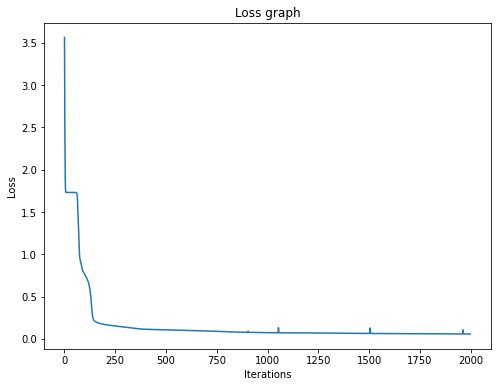

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

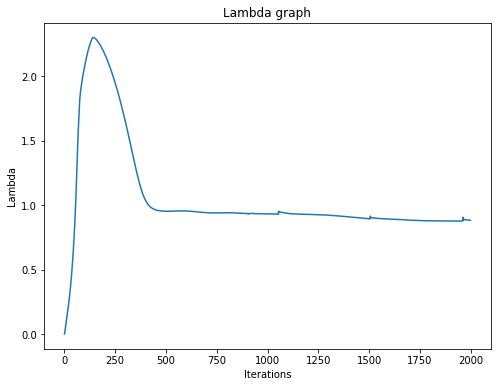

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()